In [1]:
import pandas as pd
import psycopg2
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None) 
from sklearn import preprocessing
import datetime as dt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [109]:
def flights_data(table, limit):
    conn = psycopg2.connect(database="mid_term_project", user="lhl_student", password="lhl_student", host="mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com", port="5432")
    df = pd.read_sql_query(f'''SELECT * FROM {table} ORDER BY random() LIMIT {limit};''', conn)
    print("Database downloaded successfully")
    return df

In [107]:
raw_data = flights_data('flights', 100000)

Database opened successfully


In [111]:
raw_data.to_csv(r'raw_data100k.csv', index = False)

In [124]:
raw_data.shape

(100000, 42)

In [123]:
raw_data.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-09-26,DL,DL,DL,1061,DL,N3759,1061,14524,RIC,"Richmond, VA",10397,ATL,"Atlanta, GA",1616,1612.0,-4.0,17.0,1629.0,1743.0,6.0,1758,1749.0,-9.0,0.0,None,0.0,N,102.0,97.0,74.0,1.0,481.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
1,2018-06-24,AA,AA,AA,1506,AA,N316PF,1506,11618,EWR,"Newark, NJ",13303,MIA,"Miami, FL",1727,NaN,NaN,NaN,NaN,NaN,NaN,2042,NaN,NaN,1.0,C,0.0,N,195.0,NaN,NaN,1.0,1085.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
2,2019-11-17,DL,DL_CODESHARE,DL,6227,G7,N340CA,6227,13232,MDW,"Chicago, IL",11433,DTW,"Detroit, MI",1255,1246.0,-9.0,15.0,1301.0,1441.0,8.0,1510,1449.0,-21.0,0.0,None,0.0,N,75.0,63.0,40.0,1.0,228.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
3,2018-07-18,WN,WN,WN,771,WN,N237WN,771,11697,FLL,"Fort Lauderdale, FL",15304,TPA,"Tampa, FL",1610,1610.0,0.0,58.0,1708.0,1756.0,5.0,1720,1801.0,41.0,0.0,None,0.0,N,70.0,111.0,48.0,1.0,197.0,0.0,0.0,41.0,0.0,0.0,None,NaN,NaN,None
4,2019-06-15,AA,AA_CODESHARE,AA,3124,OO,N709SK,3124,13930,ORD,"Chicago, IL",12278,ICT,"Wichita, KS",2040,2208.0,88.0,45.0,2253.0,36.0,6.0,2241,42.0,121.0,0.0,None,0.0,N,121.0,154.0,103.0,1.0,588.0,12.0,0.0,33.0,0.0,76.0,None,NaN,NaN,None


In [120]:
def clean_data(df):
    #Dropping cancelled flights
    df = df[df.diverted != 1.0]
    df = df[df.cancelled != 1.0].reset_index(drop=True)
    #Dropping null values
    df = df[df.air_time.notna()].reset_index(drop=True)
    #Filling null values
    df.dep_delay = df.dep_delay.fillna(0)
    df.arr_delay = df.arr_delay.fillna(0)
    return df.copy()

In [121]:
df = clean_data(raw_data)

In [126]:
df.shape

(98026, 17)

In [128]:
#Filtering relevant features
df = df[['fl_date', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'origin_airport_id', 'origin', 'dest_airport_id', 'dest', 'crs_dep_time',
         'dep_time', 'dep_delay', 'crs_arr_time', 'arr_time', 'arr_delay', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'distance']]

In [129]:
#Checking null values
df.isnull().sum()

fl_date                0
mkt_unique_carrier     0
mkt_carrier_fl_num     0
origin_airport_id      0
origin                 0
dest_airport_id        0
dest                   0
crs_dep_time           0
dep_time               0
dep_delay              0
crs_arr_time           0
arr_time               0
arr_delay              0
crs_elapsed_time       0
actual_elapsed_time    0
air_time               0
distance               0
dtype: int64

In [127]:
df

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance
0,2019-09-26,DL,1061,14524,RIC,10397,ATL,1616,1612.0,-4.0,1758,1749.0,-9.0,102.0,97.0,74.0,481.0
1,2019-11-17,DL,6227,13232,MDW,11433,DTW,1255,1246.0,-9.0,1510,1449.0,-21.0,75.0,63.0,40.0,228.0
2,2018-07-18,WN,771,11697,FLL,15304,TPA,1610,1610.0,0.0,1720,1801.0,41.0,70.0,111.0,48.0,197.0
3,2019-06-15,AA,3124,13930,ORD,12278,ICT,2040,2208.0,88.0,2241,42.0,121.0,121.0,154.0,103.0,588.0
4,2018-11-03,UA,343,11697,FLL,11618,EWR,858,856.0,-2.0,1148,1136.0,-12.0,170.0,160.0,136.0,1065.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98021,2019-02-14,AS,1078,14747,SEA,12892,LAX,1630,1813.0,103.0,1910,2127.0,137.0,160.0,194.0,131.0,954.0
98022,2018-11-15,UA,6005,11996,GSP,12264,IAD,1930,1942.0,12.0,2049,2049.0,0.0,79.0,67.0,52.0,384.0
98023,2019-04-04,AA,3089,12892,LAX,14679,SAN,1350,1344.0,-6.0,1437,1427.0,-10.0,47.0,43.0,29.0,109.0
98024,2018-05-28,WN,1364,10821,BWI,12191,HOU,1325,1345.0,20.0,1555,1542.0,-13.0,210.0,177.0,164.0,1246.0


In [133]:
IQR = (df['arr_delay'].quantile(0.85)-df['arr_delay'].quantile(0.25))
lower_outlier = df['arr_delay'].quantile(0.15) - 1.5*IQR
upper_outlier = df['arr_delay'].quantile(0.85) + 1.5*IQR
print(lower_outlier, upper_outlier)

-74.5 77.5


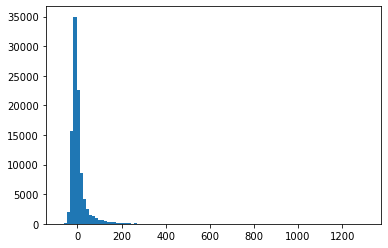

In [134]:
plt.hist(df['arr_delay'], bins=100);

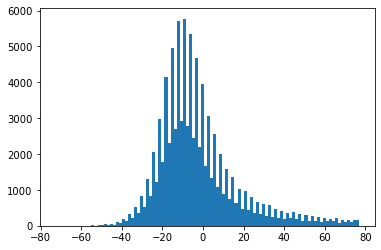

In [135]:
# get rid of outliers
df = df[(df['arr_delay'] < upper_outlier) & (df['arr_delay'] > lower_outlier)]
plt.hist(df['arr_delay'], bins=100);

In [138]:
len(df['dest'].value_counts())

369

In [139]:
def get_datetime(df):
    # change flight date to datetime
    df['fl_date'] = pd.to_datetime(df['fl_date'])
    # create year, month, day, dayofweek columns
    df['year'] = df['fl_date'].dt.year
    df['month'] = df['fl_date'].dt.month
    df['day'] = df['fl_date'].dt.day
    df['dayofweek'] = df['fl_date'].dt.dayofweek
    return df

In [140]:
df = get_datetime(df)

In [141]:
df

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,year,month,day,dayofweek
0,2019-09-26,DL,1061,14524,RIC,10397,ATL,1616,1612.0,-4.0,1758,1749.0,-9.0,102.0,97.0,74.0,481.0,2019,9,26,3
1,2019-11-17,DL,6227,13232,MDW,11433,DTW,1255,1246.0,-9.0,1510,1449.0,-21.0,75.0,63.0,40.0,228.0,2019,11,17,6
2,2018-07-18,WN,771,11697,FLL,15304,TPA,1610,1610.0,0.0,1720,1801.0,41.0,70.0,111.0,48.0,197.0,2018,7,18,2
4,2018-11-03,UA,343,11697,FLL,11618,EWR,858,856.0,-2.0,1148,1136.0,-12.0,170.0,160.0,136.0,1065.0,2018,11,3,5
5,2019-01-07,DL,5323,12266,IAH,13487,MSP,1052,1048.0,-4.0,1344,1311.0,-33.0,172.0,143.0,126.0,1034.0,2019,1,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98020,2019-08-15,F9,647,12953,LGA,11193,CVG,916,906.0,-10.0,1138,1130.0,-8.0,142.0,144.0,95.0,585.0,2019,8,15,3
98022,2018-11-15,UA,6005,11996,GSP,12264,IAD,1930,1942.0,12.0,2049,2049.0,0.0,79.0,67.0,52.0,384.0,2018,11,15,3
98023,2019-04-04,AA,3089,12892,LAX,14679,SAN,1350,1344.0,-6.0,1437,1427.0,-10.0,47.0,43.0,29.0,109.0,2019,4,4,3
98024,2018-05-28,WN,1364,10821,BWI,12191,HOU,1325,1345.0,20.0,1555,1542.0,-13.0,210.0,177.0,164.0,1246.0,2018,5,28,0


In [145]:
#df1 = df1.dropna(axis=0, subset=['dep_time', 'arr_time'])

In [116]:
#df1['dep_time'] = df1['dep_time'].astype(int)
#df1['arr_time'] = df1['arr_time'].astype(int)
#df1['dep_time'] = df1['dep_time'].astype(str)
#df1['arr_time'] = df1['arr_time'].astype(str)

In [117]:
# df1['crs_dep_time'] = df1['crs_dep_time'].astype(int)
# df1['crs_arr_time'] = df1['crs_arr_time'].astype(int)
# df1['crs_dep_time'] = df1['crs_dep_time'].astype(str)
# df1['crs_arr_time'] = df1['crs_arr_time'].astype(str)

In [118]:
# create departure hour and arrival hour columns
#df1['dep_time'] = df1['dep_time'].apply(lambda x: str(x).zfill(4))
#df1['arr_time'] = df1['arr_time'].apply(lambda x: str(x).zfill(4))
#df1['dep_h'] = df1['dep_time'].str[0:2]
#df1['arr_h'] = df1['arr_time'].str[0:2]
#df1['dep_h'] = df1['dep_h'].replace('24', '00')
#df1['arr_h'] = df1['arr_h'].replace('24', '00')

In [149]:
def to_hours(df):
    #Create departure hour and arrival hour columns
    df['crs_dep_time'] = df['crs_dep_time'].apply(lambda x: str(x).zfill(4))
    df['crs_arr_time'] = df['crs_arr_time'].apply(lambda x: str(x).zfill(4))
    df['dep_h'] = df['crs_dep_time'].str[0:2]
    df['arr_h'] = df['crs_arr_time'].str[0:2]
    df['dep_h'] = df['dep_h'].replace('24', '00')
    df['arr_h'] = df['arr_h'].replace('24', '00')
    return df

In [ ]:
df = to_hours(df)

In [150]:
df.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,year,month,day,dayofweek,dep_h,arr_h
0,2019-09-26,DL,1061,14524,RIC,10397,ATL,1616,1612.0,-4.0,1758,1749.0,-9.0,102.0,97.0,74.0,481.0,2019,9,26,3,16,17
1,2019-11-17,DL,6227,13232,MDW,11433,DTW,1255,1246.0,-9.0,1510,1449.0,-21.0,75.0,63.0,40.0,228.0,2019,11,17,6,12,15
2,2018-07-18,WN,771,11697,FLL,15304,TPA,1610,1610.0,0.0,1720,1801.0,41.0,70.0,111.0,48.0,197.0,2018,7,18,2,16,17
4,2018-11-03,UA,343,11697,FLL,11618,EWR,0858,856.0,-2.0,1148,1136.0,-12.0,170.0,160.0,136.0,1065.0,2018,11,3,5,08,11
5,2019-01-07,DL,5323,12266,IAH,13487,MSP,1052,1048.0,-4.0,1344,1311.0,-33.0,172.0,143.0,126.0,1034.0,2019,1,7,0,10,13


In [156]:
# calculate mean delay based on carrier
carrier = df.groupby('mkt_unique_carrier')['arr_delay'].mean().index.to_list()
mean_delay_carrier = df.groupby('mkt_unique_carrier')['arr_delay'].mean().to_list()

In [157]:
# calculate mean delay based on origin of the flight
origin = df.groupby('origin')['arr_delay'].mean().index.to_list()
mean_delay_origin = df.groupby('origin')['arr_delay'].mean().to_list()

In [158]:
# calculate mean delay based on destination of the flight
dest = df.groupby('dest')['arr_delay'].mean().index.to_list()
mean_delay_dest = df.groupby('dest')['arr_delay'].mean().to_list()

In [159]:
# calculate mean delay based on month
month = df.groupby('month')['arr_delay'].mean().index.to_list()
mean_delay_month = df.groupby('month')['arr_delay'].mean().to_list()

In [160]:
# calculate mean delay based on scheduled departure hour
dep_hour = df.groupby('dep_h')['arr_delay'].mean().index.to_list()
mean_delay_dep_h = df.groupby('dep_h')['arr_delay'].mean().to_list()

# calculate mean delay based on scheduled arrival hour
arr_hour = df.groupby('arr_h')['arr_delay'].mean().index.to_list()
mean_delay_arr_h = df.groupby('arr_h')['arr_delay'].mean().to_list()

In [161]:
df_carrier_delays = pd.DataFrame({'carrier': carrier, 'mean_delay_carrier': mean_delay_carrier})
df_origin_delays = pd.DataFrame({'origin': origin, 'mean_delay_origin': mean_delay_origin})
df_dest_delays = pd.DataFrame({'dest': dest, 'mean_delay_dest': mean_delay_dest})
df_month_delays = pd.DataFrame({'month': month, 'mean_delay_month': mean_delay_month})
df_dep_h_delays = pd.DataFrame({'dep_h': dep_hour, 'mean_delay_dep_h': mean_delay_dep_h})
df_arr_h_delays = pd.DataFrame({'arr_h': arr_hour, 'mean_delay_arr_h': mean_delay_arr_h})

### Create a dataframe with columns from the test file

In [162]:
df_test = df[['year', 'month', 'day', 'dayofweek', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'origin',
               'dest', 'crs_dep_time', 'dep_h', 'crs_arr_time', 'arr_h', 'crs_elapsed_time', 'distance', 'arr_delay']]

In [163]:
df_test.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay
0,2019,9,26,3,DL,1061,RIC,ATL,1616,16,1758,17,102.0,481.0,-9.0
1,2019,11,17,6,DL,6227,MDW,DTW,1255,12,1510,15,75.0,228.0,-21.0
2,2018,7,18,2,WN,771,FLL,TPA,1610,16,1720,17,70.0,197.0,41.0
4,2018,11,3,5,UA,343,FLL,EWR,0858,08,1148,11,170.0,1065.0,-12.0
5,2019,1,7,0,DL,5323,IAH,MSP,1052,10,1344,13,172.0,1034.0,-33.0


### Merge dataframes based on historical summary statistics

#### Add column for carrier delay

In [164]:
df_merged = df_test.merge(df_carrier_delays, how='left', left_on='mkt_unique_carrier' , right_on='carrier')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,carrier,mean_delay_carrier
0,2019,9,26,3,DL,1061,RIC,ATL,1616,16,1758,17,102.0,481.0,-9.0,DL,-5.265489
1,2019,11,17,6,DL,6227,MDW,DTW,1255,12,1510,15,75.0,228.0,-21.0,DL,-5.265489
2,2018,7,18,2,WN,771,FLL,TPA,1610,16,1720,17,70.0,197.0,41.0,WN,-1.005475
3,2018,11,3,5,UA,343,FLL,EWR,0858,08,1148,11,170.0,1065.0,-12.0,UA,-2.704337
4,2019,1,7,0,DL,5323,IAH,MSP,1052,10,1344,13,172.0,1034.0,-33.0,DL,-5.265489


In [165]:
df_merged = df_merged.drop(columns='carrier')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier
0,2019,9,26,3,DL,1061,RIC,ATL,1616,16,1758,17,102.0,481.0,-9.0,-5.265489
1,2019,11,17,6,DL,6227,MDW,DTW,1255,12,1510,15,75.0,228.0,-21.0,-5.265489
2,2018,7,18,2,WN,771,FLL,TPA,1610,16,1720,17,70.0,197.0,41.0,-1.005475
3,2018,11,3,5,UA,343,FLL,EWR,0858,08,1148,11,170.0,1065.0,-12.0,-2.704337
4,2019,1,7,0,DL,5323,IAH,MSP,1052,10,1344,13,172.0,1034.0,-33.0,-5.265489


#### Add column for origin delay

In [166]:
df_merged = df_merged.merge(df_origin_delays, how='left', left_on='origin' , right_on='origin')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin
0,2019,9,26,3,DL,1061,RIC,ATL,1616,16,1758,17,102.0,481.0,-9.0,-5.265489,-3.171779
1,2019,11,17,6,DL,6227,MDW,DTW,1255,12,1510,15,75.0,228.0,-21.0,-5.265489,1.400000
2,2018,7,18,2,WN,771,FLL,TPA,1610,16,1720,17,70.0,197.0,41.0,-1.005475,-1.344473
3,2018,11,3,5,UA,343,FLL,EWR,0858,08,1148,11,170.0,1065.0,-12.0,-2.704337,-1.344473
4,2019,1,7,0,DL,5323,IAH,MSP,1052,10,1344,13,172.0,1034.0,-33.0,-5.265489,-1.832694


#### Add column for destination delay

In [167]:
df_merged = df_merged.merge(df_dest_delays, how='left', left_on='dest' , right_on='dest')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin,mean_delay_dest
0,2019,9,26,3,DL,1061,RIC,ATL,1616,16,1758,17,102.0,481.0,-9.0,-5.265489,-3.171779,-4.488010
1,2019,11,17,6,DL,6227,MDW,DTW,1255,12,1510,15,75.0,228.0,-21.0,-5.265489,1.400000,-5.236034
2,2018,7,18,2,WN,771,FLL,TPA,1610,16,1720,17,70.0,197.0,41.0,-1.005475,-1.344473,-2.165919
3,2018,11,3,5,UA,343,FLL,EWR,0858,08,1148,11,170.0,1065.0,-12.0,-2.704337,-1.344473,0.515535
4,2019,1,7,0,DL,5323,IAH,MSP,1052,10,1344,13,172.0,1034.0,-33.0,-5.265489,-1.832694,-6.505799


#### Add column for month delay

In [168]:
df_merged = df_merged.merge(df_month_delays, how='left', left_on='month' , right_on='month')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin,mean_delay_dest,mean_delay_month
0,2019,9,26,3,DL,1061,RIC,ATL,1616,16,1758,17,102.0,481.0,-9.0,-5.265489,-3.171779,-4.488010,-4.557066
1,2019,11,17,6,DL,6227,MDW,DTW,1255,12,1510,15,75.0,228.0,-21.0,-5.265489,1.400000,-5.236034,-3.396341
2,2018,7,18,2,WN,771,FLL,TPA,1610,16,1720,17,70.0,197.0,41.0,-1.005475,-1.344473,-2.165919,-1.217020
3,2018,11,3,5,UA,343,FLL,EWR,0858,08,1148,11,170.0,1065.0,-12.0,-2.704337,-1.344473,0.515535,-3.396341
4,2019,1,7,0,DL,5323,IAH,MSP,1052,10,1344,13,172.0,1034.0,-33.0,-5.265489,-1.832694,-6.505799,-3.962434


#### Add column for depature hour delay

In [169]:
df_merged = df_merged.merge(df_dep_h_delays, how='left', left_on='dep_h' , right_on='dep_h')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin,mean_delay_dest,mean_delay_month,mean_delay_dep_h
0,2019,9,26,3,DL,1061,RIC,ATL,1616,16,1758,17,102.0,481.0,-9.0,-5.265489,-3.171779,-4.488010,-4.557066,-0.112570
1,2019,11,17,6,DL,6227,MDW,DTW,1255,12,1510,15,75.0,228.0,-21.0,-5.265489,1.400000,-5.236034,-3.396341,-2.553715
2,2018,7,18,2,WN,771,FLL,TPA,1610,16,1720,17,70.0,197.0,41.0,-1.005475,-1.344473,-2.165919,-1.217020,-0.112570
3,2018,11,3,5,UA,343,FLL,EWR,0858,08,1148,11,170.0,1065.0,-12.0,-2.704337,-1.344473,0.515535,-3.396341,-5.223512
4,2019,1,7,0,DL,5323,IAH,MSP,1052,10,1344,13,172.0,1034.0,-33.0,-5.265489,-1.832694,-6.505799,-3.962434,-3.975798


#### Add column for arrival hour delay

In [170]:
df_merged = df_merged.merge(df_arr_h_delays, how='left', left_on='arr_h' , right_on='arr_h')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin,mean_delay_dest,mean_delay_month,mean_delay_dep_h,mean_delay_arr_h
0,2019,9,26,3,DL,1061,RIC,ATL,1616,16,1758,17,102.0,481.0,-9.0,-5.265489,-3.171779,-4.488010,-4.557066,-0.112570,-0.849327
1,2019,11,17,6,DL,6227,MDW,DTW,1255,12,1510,15,75.0,228.0,-21.0,-5.265489,1.400000,-5.236034,-3.396341,-2.553715,-2.465585
2,2018,7,18,2,WN,771,FLL,TPA,1610,16,1720,17,70.0,197.0,41.0,-1.005475,-1.344473,-2.165919,-1.217020,-0.112570,-0.849327
3,2018,11,3,5,UA,343,FLL,EWR,0858,08,1148,11,170.0,1065.0,-12.0,-2.704337,-1.344473,0.515535,-3.396341,-5.223512,-4.833962
4,2019,1,7,0,DL,5323,IAH,MSP,1052,10,1344,13,172.0,1034.0,-33.0,-5.265489,-1.832694,-6.505799,-3.962434,-3.975798,-4.041526


In [171]:
data = df_merged.copy()

In [172]:
data = data.drop(columns=['crs_dep_time', 'crs_arr_time'])
data.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,dep_h,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin,mean_delay_dest,mean_delay_month,mean_delay_dep_h,mean_delay_arr_h
0,2019,9,26,3,DL,1061,RIC,ATL,16,17,102.0,481.0,-9.0,-5.265489,-3.171779,-4.488010,-4.557066,-0.112570,-0.849327
1,2019,11,17,6,DL,6227,MDW,DTW,12,15,75.0,228.0,-21.0,-5.265489,1.400000,-5.236034,-3.396341,-2.553715,-2.465585
2,2018,7,18,2,WN,771,FLL,TPA,16,17,70.0,197.0,41.0,-1.005475,-1.344473,-2.165919,-1.217020,-0.112570,-0.849327
3,2018,11,3,5,UA,343,FLL,EWR,08,11,170.0,1065.0,-12.0,-2.704337,-1.344473,0.515535,-3.396341,-5.223512,-4.833962
4,2019,1,7,0,DL,5323,IAH,MSP,10,13,172.0,1034.0,-33.0,-5.265489,-1.832694,-6.505799,-3.962434,-3.975798,-4.041526


In [177]:
data.shape

(93306, 19)

In [178]:
data['dep_h'] = data['dep_h'].astype(int)
data['arr_h'] = data['arr_h'].astype(int)
data.dtypes

year                    int64
month                   int64
day                     int64
dayofweek               int64
mkt_unique_carrier     object
mkt_carrier_fl_num      int64
origin                 object
dest                   object
dep_h                   int64
arr_h                   int64
crs_elapsed_time      float64
distance              float64
arr_delay             float64
mean_delay_carrier    float64
mean_delay_origin     float64
mean_delay_dest       float64
mean_delay_month      float64
mean_delay_dep_h      float64
mean_delay_arr_h      float64
dtype: object

In [180]:
data = data.drop(columns=['mkt_carrier_fl_num']).copy()

In [206]:
df.shape[0]

93306

In [181]:
data.dtypes

year                    int64
month                   int64
day                     int64
dayofweek               int64
mkt_unique_carrier     object
origin                 object
dest                   object
dep_h                   int64
arr_h                   int64
crs_elapsed_time      float64
distance              float64
arr_delay             float64
mean_delay_carrier    float64
mean_delay_origin     float64
mean_delay_dest       float64
mean_delay_month      float64
mean_delay_dep_h      float64
mean_delay_arr_h      float64
dtype: object

In [73]:
data.head()

,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,year,month,day,dayofweek,dep_h,arr_h
0,DL,1736,10397,ATL,11066,CMH,2244,2325.0,41.0,0023,52.0,29.0,99.0,87.0,63.0,447.0,2019,8,21,2,22,0
1,WN,274,14679,SAN,10423,AUS,0635,629.0,-6.0,1125,1113.0,-12.0,170.0,164.0,142.0,1164.0,2018,1,31,2,6,11
2,WN,4431,13891,ONT,14831,SJC,0640,633.0,-7.0,0750,732.0,-18.0,70.0,59.0,51.0,333.0,2018,7,1,6,6,7
3,AA,3153,11298,DFW,12511,JLN,1020,1014.0,-6.0,1142,1122.0,-20.0,82.0,68.0,53.0,327.0,2019,1,4,4,10,11
4,B6,702,12478,JFK,10792,BUF,0939,931.0,-8.0,1104,1042.0,-22.0,85.0,71.0,51.0,301.0,2018,9,2,6,9,11


In [184]:
# function to label encode desired columns
def label_encode(df, cols):
    le = preprocessing.LabelEncoder()
    for i in cols:
        df[i] = le.fit_transform(df[i].values)
    return df

In [75]:
data['crs_arr_time'] = data['crs_arr_time'].astype(float)

In [185]:
# define columns to encode
cols_to_encode = ['mkt_unique_carrier', 'origin', 'dest']
data = label_encode(data, cols_to_encode)
data.dtypes

year                    int64
month                   int64
day                     int64
dayofweek               int64
mkt_unique_carrier      int64
origin                  int64
dest                    int64
dep_h                   int64
arr_h                   int64
crs_elapsed_time      float64
distance              float64
arr_delay             float64
mean_delay_carrier    float64
mean_delay_origin     float64
mean_delay_dest       float64
mean_delay_month      float64
mean_delay_dep_h      float64
mean_delay_arr_h      float64
dtype: object

In [182]:
data = data.drop(columns=['actual_elapsed_time'])

KeyError: "['actual_elapsed_time'] not found in axis"

In [88]:
data = data.drop(columns=['arr_h'])
data = data.drop(columns=['air_time'])

KeyError: "['arr_h'] not found in axis"

In [96]:
data = data.drop(columns=['dep_delay', 'dep_time'])

In [89]:
data = label_encode(data, ['mkt_carrier_fl_num'])

In [194]:
data.dtypes

year                    int64
month                   int64
day                     int64
dayofweek               int64
mkt_unique_carrier      int64
origin                  int64
dest                    int64
dep_h                   int64
arr_h                   int64
crs_elapsed_time      float64
distance              float64
arr_delay             float64
mean_delay_carrier    float64
mean_delay_origin     float64
mean_delay_dest       float64
mean_delay_month      float64
mean_delay_dep_h      float64
mean_delay_arr_h      float64
dtype: object

In [199]:
data = data.drop(columns=['mean_delay_month'])

In [207]:
data.to_csv('test_data.csv')

In [200]:
scaler = preprocessing.StandardScaler()
X = data.drop(columns='arr_delay').values
y = data['arr_delay'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Standardize the data using only statistics from the training set
# (always assume no knowledge of the test set for most unbiased performance estimate)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [201]:
reg = LinearRegression()
k_folds = 5

# Cross-validation
cv_r2 = cross_val_score(reg, X_train, y_train, cv=k_folds, scoring='r2')

# Train model on the entire training set
reg.fit(X_train, y_train)

# Test the model
y_pred_linreg = reg.predict(X_test)

# Calculate metrics
r2_linreg = r2_score(y_test, y_pred_linreg)
rmse_linreg = mean_squared_error(y_test, y_pred_linreg, squared=False)

# Compare traing to test accuracy
linreg_training_accuracy = reg.score(X_train, y_train)
linreg_test_accuracy = reg.score(X_test, y_test)

# Print results
print('Linear Regression')
print('==================')
print(f'Cross-validated R^2\nMean: {cv_r2.mean():.4f}\nStd.: {cv_r2.std():.4f}')
print(f'R^2: {r2_linreg:.4f}')
print(f'RMSE: {rmse_linreg:.4f}')
print(f'Training accuracy: {linreg_training_accuracy:.4f}')
print(f'Test accuracy: {linreg_test_accuracy:.4f}')

Linear Regression
Cross-validated R^2
Mean: 0.0364
Std.: 0.0029
R^2: 0.0372
RMSE: 19.6144
Training accuracy: 0.0369
Test accuracy: 0.0372


In [202]:
# Create polynomial feature set and train model
Xpoly_train = PolynomialFeatures(degree=2).fit_transform(X_train)
Xpoly_test = PolynomialFeatures(degree=2).fit_transform(X_test)

# Train and test the model
reg.fit(Xpoly_train, y_train)
ypoly_train_pred = reg.predict(Xpoly_train)
ypoly_test_pred = reg.predict(Xpoly_test)

# Calculate metrics
r2_polyreg = r2_score(y_test, ypoly_test_pred)
rmse_polyreg = mean_squared_error(y_test, ypoly_test_pred, squared=False)

# Check performance on train and test set
r2poly_train = r2_score(y_train, ypoly_train_pred)
r2poly_test = r2_score(y_test, ypoly_test_pred)

# Print results
print('Linear Regression with Polynomial Degree = 2')
print('============================================')
print(f'Number of polynomial features: {Xpoly_train.shape[1]}')
print(f'R^2: {r2_polyreg:.4f}')
print(f'RMSE: {rmse_polyreg:.4f}')
print(f'Training accuracy: {r2poly_train:.4f}\nTest accuracy: {r2poly_test:.4f}')

Linear Regression with Polynomial Degree = 2
Number of polynomial features: 120
R^2: 0.0412
RMSE: 19.5741
Training accuracy: 0.0457
Test accuracy: 0.0412


In [203]:
# define hyperparameters
param_grid = {'alpha': [0.1, 1, 5, 10]}

# create an instance of the model
rr = Ridge()
k_folds = 5

# perform cross validation and grid search
grid = GridSearchCV(estimator=rr, param_grid=param_grid, cv=k_folds, scoring='r2', n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Check best hyperparameters and train the best model
best_r2_rr = grid_result.best_score_  
best_alpha_rr = grid_result.best_params_['alpha']
best_rr_model = grid_result.best_estimator_ 

# Predict results
y_pred_rr = best_rr_model.predict(X_test)

# Calculate metrics
r2_test_rr = r2_score(y_test, y_pred_rr)
rmse_rr = mean_squared_error(y_test, y_pred_rr, squared=False)

# Check training and test accuracy
rr_training_accuracy = best_rr_model.score(X_train, y_train)
rr_test_accuracy = best_rr_model.score(X_test, y_test)

# Print results
print('Ridge Regression')
print('================')
print(f'The best hyperparameter settings achieve a cross-validated R^2 of: {best_r2_rr:.4f}\nAlpha:\t{best_alpha_rr}')
print(f'R^2: {r2_test_rr:.4f}')
print(f'RMSE:  {rmse_rr:.4f}')
print(f'Training accuracy: {rr_training_accuracy:.4f},    Test accuracy: {rr_test_accuracy:.4f}')

Ridge Regression
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0364
Alpha:	10
R^2: 0.0373
RMSE:  19.6143
Training accuracy: 0.0369,    Test accuracy: 0.0373


In [190]:
# define hyperparameters
param_grid = {'alpha': [50000, 60000, 80000, 100000]}

# create an instance of the model
rr = Ridge()
k_folds = 5

# perform cross validation and grid search
grid = GridSearchCV(estimator=rr, param_grid=param_grid, cv=k_folds, scoring='r2', n_jobs=-1)
grid_result = grid.fit(Xpoly3_train, y_train)

# Check best hyperparameters and train the best model
best_r2_poly = grid_result.best_score_   
best_alpha_poly = grid_result.best_params_['alpha']
best_rr_poly = grid_result.best_estimator_

# Predict results
y_pred_poly = best_rr_poly.predict(Xpoly3_test)

# Calculate metrics
r2_test_poly = r2_score(y_test, y_pred_poly)
rmse_rr_poly = mean_squared_error(y_test, y_pred_poly, squared=False)

# Check training and test accuracy
rr_poly_training_accuracy = best_rr_poly.score(Xpoly3_train, y_train)
rr_poly_test_accuracy = best_rr_poly.score(Xpoly3_test, y_test)

# Print results
print('Ridge Regresssion on Polynomial (Degree = 3) with grid search')
print('=============================================================')
print(f'The best hyperparameter settings achieve a cross-validated R^2 of: {best_r2_poly:.4f}\nAlpha:\t{best_alpha_poly}')
print(f'R^2 :{r2_test_poly:.4f}')
print(f'RMSE:  {rmse_rr_poly:.4f}')
print(f'Training accuracy: {rr_poly_training_accuracy:.4f},    Test accuracy: {rr_poly_test_accuracy:.4f}')

NameError: name 'Xpoly3_train' is not defined